In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from MNNCA import CA, totalistic
import pygame, pygame_gui

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] + blur[count_i, count_j] * 10
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] * blur[count_i, count_j]
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order
    
def WHEEL_param(param, direction, increment):
    
    return 10 ** (np.log10(param) + direction * increment)

# Test

In [3]:
CHANNELS=4 # number of channels in grid
FILTERS=4 # number of filters per channel
NET_SIZE=[32, 32, 32] # number of hidden neurons per layer

RADIUS=12

ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, NET_SIZE=NET_SIZE, RADIUS=RADIUS).cuda() 

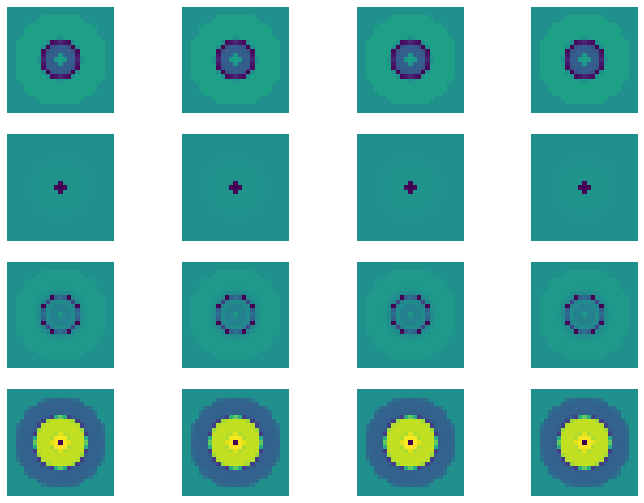

In [4]:
kernels = torch.cat([k for k in ca.rule.kernels], dim=0).cpu().detach().numpy()
# kernels = totalistic(ca.rule.kernels[0].cpu().detach()).numpy()

num_plot_kernels = np.min([6, CHANNELS])
fig, axes = plt.subplots(FILTERS, num_plot_kernels, figsize=(12, 9))

# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(kernels[0, i, :, :])
#     ax.axis('off')
    

for i in range(FILTERS):
    
    if FILTERS > 1:
        for j in range(num_plot_kernels):
            kplot = kernels[i, j, :, :]
            kmax = np.max(np.abs(kplot))
            axes[i, j].imshow(kplot, vmin=-kmax, vmax=kmax)
            axes[i, j].axis('off')
    else:
        for j in range(num_plot_kernels):
            kplot = kernels[i, j, :, :]
            kmax = np.max(np.abs(kplot))
            axes[j].imshow(kplot, vmin=-kmax, vmax=kmax)
            axes[j].axis('off')

In [5]:
# brush properties
r = 20
s = 1

In [ ]:
# resolution of grid
RESX=321
RESY=161

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 3
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, CHANNELS)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
def show_wheel_info(param, name):
    font = pygame.font.SysFont("Noto Sans", 12)
    info_str = f'{name}: {param:.4f}'
    info_txt = font.render(info_str, 1, pygame.Color("white"))
    info_bg = pygame.Surface((info_txt.get_height(),info_txt.get_width()))  # the size of your rect
    info_bg.set_alpha(50)                # alpha level
    info_bg.fill((255,255,255))           # this fills the entire surface

    info_surf = pygame.Surface((info_bg.get_height(), info_bg.get_width()))
    pos = (0., 0.)
    info_surf.blit(info_bg, pos)
    info_surf.blit(info_txt, pos)
    return info_surf
######################################

# CENTER SEED
seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
seed[:, 3:, RESX//2, RESY//2] = 1
state = seed.clone()

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # pick another random CA
                ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, NET_SIZE=NET_SIZE, RADIUS=RADIUS).cuda() 
                
                
#             if event.type == pygame.VIDEORESIZE:
#                 print(event.w, event.h)
#                 surface = pygame.display.set_mode((event.w, event.h),
#                                               pygame.RESIZABLE)
            if event.type== pygame.KEYDOWN and event.key == pygame.K_t:
                ca.rule.totalistic = not ca.rule.totalistic
            if event.type== pygame.KEYDOWN and event.key == pygame.K_g:
                ca.rule.use_growth_kernel = not ca.rule.use_growth_kernel
            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = seed.clone()
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        # scroll to permute through which channels get visualized
        if WHEEL_trigger:
            #cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
            update_rate = WHEEL_param(update_rate, direction, 1./3.)
            
        nx = state.cpu()[:, cdim_order].numpy()[0, 0:3, :, :].transpose(1, 2, 0)
#         nx = state.cpu()[:, cdim_order]
#         nx = torch.cat([
#             nx[:,0:CHANNELS//3].mean(dim=1, keepdim=True), 
#             nx[:,CHANNELS//3:2*CHANNELS//3].mean(dim=1, keepdim=True), 
#             nx[:,2*CHANNELS//3:].mean(dim=1, keepdim=True)], dim=1)[0].numpy().transpose(1, 2, 0)
        nx = np.clip(nx, 0, 1)*255
#         nx = nx + 128
#         nx = (nx + 1)/2 * 255
#         nx = nx.astype(np.uint8)
        if time_ticking:
#             state = ca.forward_perception(state, dt=1)
#             state = ca.forward_masked(state)
            state = ca.forward(state, update_rate= update_rate)
            ticker += 1
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2)
#             state = torch.where(R > 0.5, state, state - R)
#             state = (state - (R + 0.4*torch.cos(10*X + ticker/20).abs()).cuda()) #  * (1 - amp*(torch.cos(X*w) + torch.cos(Y*w))).cuda()
#             state = state - (torch.sin(R*10 + ticker/60).abs()/2).cuda()
            state = state - R.cuda()/3
#             state[:, :, 0*RESX//10:10*RESX//10, 4*RESY//10:6*RESY//10] = torch.cuda.FloatTensor([-127. * np.sin(ticker / 20.)])

        if export_imgs and time_ticking:
            imgs.append(nx)
    
#         signal_injection[:, noise_idx, :, :] = noise_amp * torch.randn(size=(signal_injection[:, noise_idx, :, :].shape))
#         signal_injection = signal_injection.to('cuda')
#         state = state + signal_injection

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        upscaled_screen.blit(show_wheel_info(update_rate, 'update_rate'), (RESXup - 100,0))
        pygame.display.flip()
        clock.tick(120)
        
pygame.quit()


In [ ]:
state.var(dim=1).cpu().numpy()

In [ ]:
plt.hist(state.cpu().numpy().reshape(-1)); plt.yscale('log')

In [ ]:
state.var(dim=1, keepdim=True).shape

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 90, (RESX, RESY), 3)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

In [ ]:
plt.hist(state.reshape(-1).cpu().detach().numpy())